In [11]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
import csv
import os
import ntpath
import networkx as nx
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
from spotlight import annotate
from functools import partial
from itertools import islice
from sklearn.metrics.pairwise import cosine_similarity
import numpy

#A function for Slicing a dictionary
'''n is the slice rate 
iterable -> the dictionary to be sliced. 
convert the dictionary to a list and use islice function to slice it
'''
def dicslice(n, iterable):
    return list(islice(iterable, n))

#nltk.download('punkt') # if necessary...
''' a stemmer which would be used to reduce 
each word to its root equivalence is built.
this will help reduce the noise in the text document.
this is also built alongside punctuation removal.
'''

'''Function that creates tokens to use.'''
def stem_tokens(tokens):
    stemmer = nltk.stem.porter.PorterStemmer()
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

def cosine_sim(text1, text2):
    vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words=STOPWORDS)    
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]
def ProjectTrust(targetP):
    
    targetp = ntpath.basename(targetP)
    testfile = targetp

    newProjectReadme = []
    with open(r"githubtestreadme/"+testfile,'r') as newPorject:
        dataNew = newPorject.read()
        newProjectReadme.append(dataNew.replace("\n"," "))

    '''for both the new and old readme files, append the name of the files to a 
    list containing the readme texts for each document'''
    path = "githubreadmefiles/*"
    oldProjectReadme = []
    readmewithname = []
    for fname in glob.glob(path):
        with open(fname, 'r') as infile:
            data = infile.read()
            oldProjectReadme.append(data.replace("\n",""))
            readmewithname.append((fname,data.replace("\n","")))


    '''put the path of each of the read me file into first_elts'''
    first_elts = [x[0] for x in readmewithname]
    #print(first_elts)
    '''put the readme file in a list called second_elts'''
    #project list
    second_elts = [x[1] for x in readmewithname]
    
    #compute cosine similarity of new and old readme files. this is done by 
        #comparing each of the old readme with the new readme
        
    similarityvalues = []
    for i in range(len(second_elts)):
        sim = cosine_sim(second_elts[i],newProjectReadme[0])
        similarityvalues.append(sim)
    print(sim)
        #print("Similarity between old and new Readme %d = %f"%(i,sim))

    #compute the maximum of the similarity value and get the path.
    maxi = 0
    for i in range(len(similarityvalues)):
        if similarityvalues[i] > maxi:
            maxi = similarityvalues[i]
            maxIndex = i

    #ntpath.basename extracts the name of a file from a path
    targetp = ntpath.basename(first_elts[maxIndex])

    '''Graph of fork activities on github'''
    
    F= nx.Graph()
    fork_headers = ['user_id','projectid']
    forks = pd.read_csv('trialdata/fork.csv',header=None,skiprows=1, names=fork_headers)
    fusers = forks.user_id.tolist()
    fproj = forks.projectid.tolist()
    #print(forks.head())
    F.add_edges_from(forks.values)

    '''Graph of watch or stargazers activities on github'''
    W= nx.Graph()
    watch_headers = ['user_id','projectid']
    watchers = pd.read_csv('trialdata/watchers.csv',header=None,skiprows=1, names=watch_headers)
    wusers = watchers.user_id.tolist()
    wproj = watchers.projectid.tolist()
    #print(watchers.head())
    W.add_edges_from(watchers.values)

    '''Graph of pullrequests activities on github'''
    P= nx.Graph()
    pullrequest_headers = ['user_id','projectid']
    pullrequest = pd.read_csv('trialdata/pullrequest.csv',header=None,skiprows=1, names=pullrequest_headers)
    pusers = pullrequest.user_id.tolist()
    pproj = pullrequest.projectid.tolist()
    #print(pullrequest.head())
    P.add_edges_from(pullrequest.values)

    '''Graph of commits activities on github'''
    C= nx.Graph()
    commit_headers = ['user_id','projectid']
    commits = pd.read_csv('trialdata/commits.csv',header=None,skiprows=1, names=commit_headers)
    cusers = commits.user_id.tolist()
    cproj = commits.projectid.tolist()
    #print(commits.head())
    C.add_edges_from(commits.values)

    '''compute the total users and total projects in the four graphs. using set excludes
    repeatition of any user or project
    '''
    totalusers = set(fusers + wusers + cusers + pusers)
    totalprojec = set(fproj + wproj + cproj + pproj)
    c = 0
    #generate a new directed graph where there is a common edge between the existing four graphs.
    '''
    This new graph is the graph of all developers that meets up with the four criteria
    '''
    G = nx.DiGraph()
    for i in totalusers:
        for j in totalprojec:
            if F.has_edge(i,j) and W.has_edge(i,j) and P.has_edge(i,j) and C.has_edge(i,j):
                #print('user %s found in (%s, %s)'% (i,i,j))
                G.add_edge(i,j)
                c = c + 1

    occur_users = [u[0] for u in G.edges()]
    testusers = occur_users
    occur_projects = [u[1] for u in G.edges()]
    #count the number project of each user occurence in the trust graph  
    usercount = Counter(occur_users)
    #print('usercount',\n')

    nx.draw(F,with_labels=True,node_color='g')
    plt.savefig('fork graph')
    #plt.show()

    nx.draw(W,with_labels=True,node_color='b')
    plt.savefig('watch graph')
    #plt.show()

    nx.draw(G,with_labels = True,node_color='y')
    plt.savefig('Trust Graph')
    plt.show()
    #max(occur_users, key=occur_users.count)

    #print( 'Users with the four characteristics to a project ',G.edges() )
    #Generic Recommendation. without consideration of experience level 
    Recommended_users = [u[0] for u in G.in_edges(targetp)]

    '''
    #normalize the experience level by dividing the number of projects a developer has worked 
    on by the total projects
    occur_projects = projects with developers that met up with the four criteria above
    '''
    j = dict(usercount)

    normUsercount = {}
    for key,value in j.items():
        normUsercount[key] = value/len(occur_projects)
    print(normUsercount)

    '''Gets only developers who are involved in the most similar project we have identified earlier
    u[0] = userid
    u[1] = identified project
    QUsers = Qualified developers involved with identified similar project
    '''
    dicOfQualifiedUsers = {}
    for u in G.in_edges(targetp):
        dicOfQualifiedUsers[u[0]] = u[1]
    
    QUsers = [] 
    for key,value in dicOfQualifiedUsers.items():
        QUsers.append(key)

    '''
    # getting the experience level of only qualified users in the normUserCount experience level above.
    key = userid in normUsercount(which is experience level of all users in the new trust graph G)
    value = experience level value.
    '''  

    QUserExp = {}
    print('user',' value')
    for user in QUsers:
        for key,value in normUsercount.items():
            if user == key:
                print(key,' ',value,'\n')
                QUserExp[user] = value

    #appending the concepts of the old readme file that selected users have worked with to the user,
    #getting project the Qusers were trusted partakers of 
    #for x in occur_users,occur_projects:

    '''
    extract all other projects the Quser or Trusted User has participated in
    zip(occur_users,occur_projects) brings list together and makes them a tuple of user-project.
    the code below simply converts the user project tuple to a user-project dictionary.
    then checks to see if a user in the occured users from graph G is a qualified developer then assign the involved
    projet as key, value pair repespectively
    '''
    QUserProj = {}
    for user, project in zip(occur_users, occur_projects):
        if user in QUserExp:
            QUserProj[user] = project
    '''
    read in the programming languages of projects.
    #convert the projects and programming language into 'dicti'
    key = projects
    value = list of programming languages used in a project
    l2[1:]=  takes off all the keys in the programming language (prolang) dictionary which is project names
    and returns only the list of programming languages involoved in it.
    'p'+l2[0] = appends a p to the id of each project.
    '''
    prolang = []
    with open(r"githubProjLang/languages.csv",'r') as Prolang:
        reader = csv.reader(Prolang)
        for row in reader:
            prolang.append(row)
    dicti = {}
    for l2 in prolang:
        dicti['p'+l2[0]] = l2[1:]

    '''
    generate a programming language profile of each qualified developer in quserproj.
    QUsersprofilecount counts the number of programming languages a developer has been involved in.
    '''
    QUsersProfile = {}
    for key,value in QUserProj.items():
        for key1,value1 in dicti.items():
            if value==key1:
                QUsersProfile[key] = value1
    QUsersProfileCount = {}
    for key,value in QUsersProfile.items():
        QUsersProfileCount[key] = len(value)

    '''
    read in the programming languages used in the new project which we are recommending developers
    newdicti is a dictionary containing the new project name as key and the list of programming languages as value
    '''
    newprolang = []
    with open("newprojectreadme/pnewlang.csv",'r') as NewProlang:
        reader = csv.reader(NewProlang)
        for row in reader:
            newprolang.append(row)
    newdicti = {}
    for l2 in newprolang:
        newdicti[l2[0]] = l2[1:]
    print(newprolang,newdicti)

    '''
    evaluate the number of languages each user has that is common to the new project's programming languages.
    '''
    langsim = {}
    for key,value in QUsersProfile.items():
        lang_sim = set(value).intersection(set(newdicti['pnew']))
        langsim[key] = len(lang_sim)/len(set(newdicti['pnew']))
    '''
    compute total relevance or trust level a project has for each qualified developer by summing up languages
    similarity score and experience level
    '''
    totalRel = {}
    for key,value in QUserExp.items():
        for k1,v2 in langsim.items():
            if key in langsim and k1 in QUserExp:
                totalRel[key] = QUserExp[key] + langsim[key]            

    '''
    Rank the users based on their total relevance level or projectTrust level.
    top n = 2, developers are recommended. by slicing down the ranked recommendation list
    '''
    #sorted(totalRel,key=totalRel.get, reverse=True)
    Recommendation_list = {key: rank for rank, key in enumerate(\
                                sorted(totalRel, key=totalRel.get, reverse=True), 1)}
    n_recomm = dicslice(2,Recommendation_list.items())
    predicted_users = [x for x in Recommendation_list]


    '''
    Test for accuracy which is the correctly recommended users from the testusers list in the first notebook
    '''
    count = 0
    real_predicted = []
    for user in predicted_users:
        if user in testusers:
            count = count + 1
            real_predicted.append(user)
    acurracy = count/len(set(testusers))

    print('Maximum similarity value is %f index %d'%(maxi,maxIndex))
    print('Similar project is ',ntpath.basename(first_elts[maxIndex]))
    print('total relevance level',totalRel)
    print('Recommendation List =',Recommendation_list)
    print('Top two recommended developers for the new project',n_recomm)
    print('Recommended developers = ',predicted_users)
    print('testusers',testusers)
    print('realpredicted',real_predicted)
    print('Recommendation Acurracy = ',acurracy)

0.529308554889


/home/nkorojoseph/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/nkorojoseph/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/nkorojoseph/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/nkorojoseph/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnin

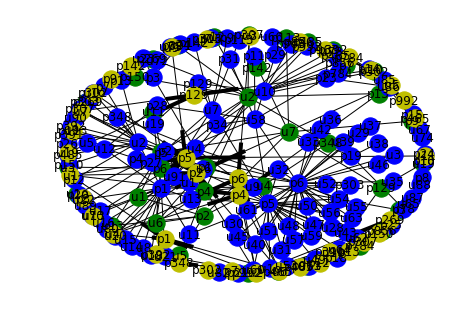

{'u6': 0.07692307692307693, 'u2': 0.28846153846153844, 'u19': 0.019230769230769232, 'u1': 0.07692307692307693, 'u5': 0.038461538461538464, 'u11': 0.019230769230769232, 'u7': 0.11538461538461539, 'u13': 0.038461538461538464, 'u10': 0.11538461538461539, 'u4': 0.1346153846153846, 'u3': 0.019230769230769232, 'u1o': 0.019230769230769232, 'u9': 0.038461538461538464}
user  value
u4   0.1346153846153846 

[['pnew', 'PHP', 'JavaScript', 'Python', 'Shell', 'Lua', 'C', 'VimL']] {'pnew': ['PHP', 'JavaScript', 'Python', 'Shell', 'Lua', 'C', 'VimL']}
Maximum similarity value is 0.977429 index 11
Similar project is  p3
total relevance level {'u4': 0.5631868131868132}
Recommendation List = {'u4': 1}
Top two recommended developers for the new project [('u4', 1)]
Recommended developers =  ['u4']
testusers ['u6', 'u6', 'u6', 'u6', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u2', 'u19', 'u1', 'u1', 'u1', 'u1', 'u5', 'u5', 'u11', 'u7', 'u7', 'u7', 'u7', 'u7', 'u7', 

In [12]:
ProjectTrust('p52')